### Ray Paths and TT Curves for the Moon

Written by *Nick Mancinelli*, July 2018

In [1]:
#Read in Alex's Weber model 
%matplotlib inline

model_string  = 'khan'

import pandas as pd

if 'khan' in model_string:
    names = ['Depth_km', 'Vs','Vp','Density']
    df = pd.read_csv('%s.txt' % model_string, delim_whitespace = True, skiprows = 0, names = names)
    
else:
    names = ['Radius_meters','Density','Vp','Vs','Dummy','Dummy','Dummy','Dummy','Dummy']
    df = pd.read_csv('%s.txt' % model_string, delim_whitespace = True, skiprows = 3, names = names)


    #Adjust units
    df['Radius_km'] = df['Radius_meters']/1000.
    df['Vp'] = df['Vp']/1000.
    df['Vs'] = df['Vs']/1000.
    df['Density'] = df['Density']/1000.
    radius_max = df.Radius_km.tolist()[-1]
    df['Depth_km'] = radius_max - df['Radius_km']
    df = df.iloc[::-1]

#Write in .nd format for taup calculation
fout = open('%s.nd' % model_string,'w')

for irow, row in df.iterrows():
    string = '%4.0f %5.1f %5.1f %5.1f\n' % (row.Depth_km, row.Vp, row.Vs, row.Density)
    
    if irow < len(df.Depth_km.tolist()) and irow > 0:
        if df.loc[irow-1].Depth_km == row.Depth_km:
            if row.Depth_km > 30. and row.Depth_km < 45.:
                fout.write('mantle\n')
            elif row.Depth_km > 1400. and row.Depth_km < 1415.:
                fout.write('outer-core\n')
            elif row.Depth_km > 1490. and row.Depth_km < 1505. and 'khan' not in model_string:
                fout.write('inner-core\n')
            elif row.Depth_km > 1445. and row.Depth_km < 1455. and 'khan' in model_string:
                fout.write('outer-core\n')
            elif row.Depth_km > 1445. and row.Depth_km < 1455. and 'khan' in model_string:
                fout.write('outer-core\n')
        elif row.Depth_km > 1720. and row.Depth_km < 1730. and 'khan' in model_string:
            fout.write('inner-core\n')
    fout.write(string)
                
fout.close()

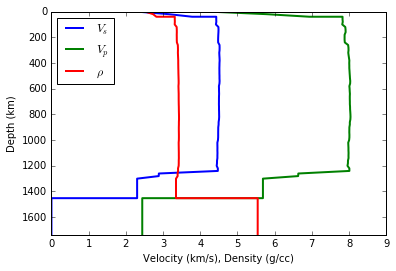

In [2]:
from matplotlib import pylab as plt

plt.figure()

lw = 2

plt.plot(df.Vs, df.Depth_km, label=r'$V_s$', lw = lw)
plt.plot(df.Vp, df.Depth_km, label=r'$V_p$', lw = lw)
plt.plot(df.Density, df.Depth_km, label=r'$\rho$', lw = lw)
_ = plt.ylim(max(df.Depth_km), min(df.Depth_km))
_ = plt.legend(loc='best')
_ = plt.ylabel('Depth (km)')
_ = plt.xlabel('Velocity (km/s), Density (g/cc)')

In [2]:
#Build taup model through obspy wrapper

import obspy
from obspy.taup import taup_create, TauPyModel
taup_create.build_taup_model('weber_minos.nd')
taup_create.build_taup_model('weber_minos_nopml.nd')
taup_create.build_taup_model('khan.nd')
model1 = TauPyModel(model="weber_minos")
model2 = TauPyModel(model="weber_minos_nopml")
model3 = TauPyModel(model="khan")

Building obspy.taup model for 'weber_minos.nd' ...
Building obspy.taup model for 'weber_minos_nopml.nd' ...
Building obspy.taup model for 'khan.nd' ...


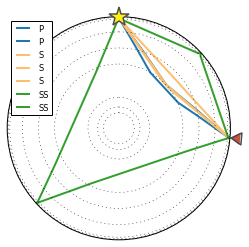

P phase arrival at 340.601 seconds
P phase arrival at 345.519 seconds
S phase arrival at 598.359 seconds
S phase arrival at 602.715 seconds
S phase arrival at 603.015 seconds
SS phase arrival at 675.702 seconds
SS phase arrival at 1460.138 seconds


In [13]:
#Plot some ray paths

for model in [model1]:
    arrivals = model.get_ray_paths(source_depth_in_km=0, distance_in_degree=95, phase_list=["P","SS","S"])
    ax = arrivals.plot_rays(legend=True)
    
for arrival in arrivals:
    print(arrival)

#### Print travel times

for arrival in arrivals:
    print(arrival, arrival.time/60.)

There were 5 epicentral distances without an arrival


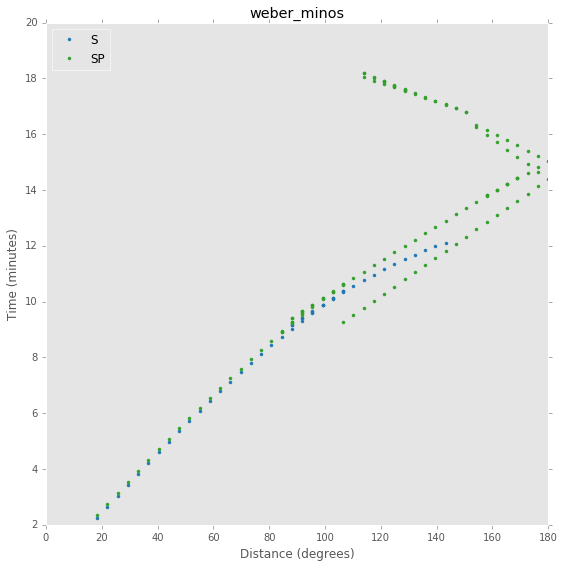

In [5]:
#Plot travel time curves

from obspy.taup import plot_travel_times

import matplotlib.pyplot as plt
plt.style.use('ggplot')



for iplt, model in enumerate(['weber_minos']):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(model)
    ax = plot_travel_times(model=model, 
                           source_depth=100, 
                           #phase_list=["S","ScS","SS"],
                           #phase_list=["P","PcP","PP","PKiKP","PKIKP","SS","SKS","PPP","Sdiff","PKP","SdiffSdiff"],
                           phase_list=["S","SP"],
                           #phase_list=["sS", "S","ScS","SS","SSS","SSSS","P","PKP","PKIKP","PcS","ScP","PcP","pS",'p','s'], 
                           npoints = 50,
                           ax=ax, fig=fig, verbose=True)
    
    

In [6]:
from numpy import arange

import pandas as pd

deldegs = arange(0, 180.5, 2.5)
event_depth = 850
model_name = 'weber'

phase_list = ["p","s","P","S","SP","PS","PP","SS","PKP","PKIKP","PKiKP","Pdiff","Sdiff","PcP","ScS","PcS","pP","sS","Pv1257P","Sv1257S"]

df = pd.DataFrame()

for deldeg in deldegs:
    arrivals = model1.get_ray_paths(source_depth_in_km=event_depth, distance_in_degree=deldeg, phase_list=phase_list)
    tmp = pd.DataFrame()
    tmp["Delta"] = [deldeg]
    
    names = []
    times = [] 
    
    for arrival in arrivals:
        for iteration in range(10):
            if arrival.name in names:
                arrival.name = arrival.name + '_'
            else:
                break
            
        names.append(arrival.name)
        times.append(arrival.time)
        
    tmp = pd.DataFrame(data=[times], columns = names, index=[deldeg])
    #tmp{}
    
    #tmp["Distance"] = deldeg

    df=df.append(tmp)
    
    
filename = 'tt_%s_event_depth_%d_km.txt' % (model_name, event_depth)
df.to_csv(filename,sep=' ', na_rep='nan', float_format = '%6.1f', quotechar=' ')

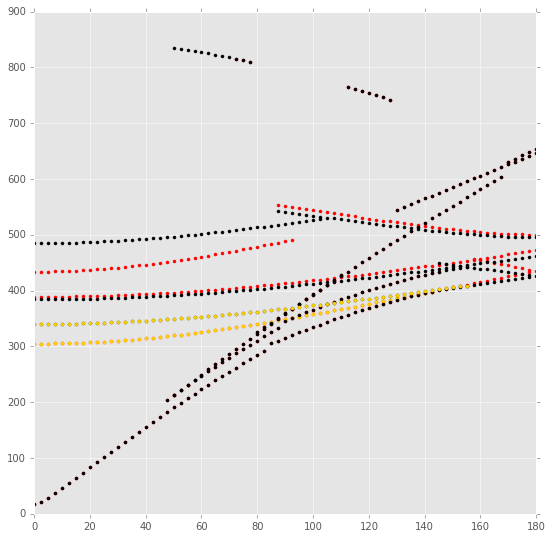

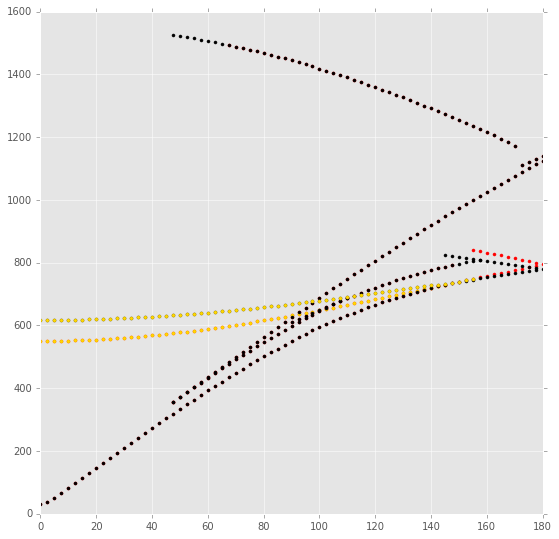

In [14]:
#df.to_csv('tmp.txt',sep=' ', float_format = '%8.1f', quoting = None)
df1 = pd.read_csv('tt_weber_event_depth_100_km.txt', delim_whitespace=True)
df2 = pd.read_csv('tt_weber_nopml_event_depth_100_km.txt', delim_whitespace=True)
#df3 = pd.read_csv('tt_khan_event_depth_100_km.txt', delim_whitespace=True)

colors = ['red','black']
labels = ['Weber','No PML']

plt.figure(1,(9,9))

for ii, df in enumerate([df1,df2]):
    plt.plot(df.index, df.p, '.',    color = colors[ii])
    plt.plot(df.index, df.P, '.',    color = colors[ii])
    plt.plot(df.index, df.pP, '.',    color = colors[ii])
    #plt.plot(df.index, df.P_,'.',   color = colors[ii])
    #plt.plot(df.index, df.P__,'.',   color = colors[ii])
    plt.plot(df.index, df.PP,'.',  color = colors[ii])
    plt.plot(df.index, df.PP_,'.',  color = colors[ii])
    #plt.plot(df.index, df.PP__,'.',  color = colors[ii])
    plt.plot(df.index, df.Pdiff,'.',  color = colors[ii])
    plt.plot(df.index, df.Pdiff_,'.',  color = colors[ii])
    plt.plot(df.index, df.PKIKP,'.',  color = colors[ii])
    plt.plot(df.index, df.PKiKP,'.',  color = colors[ii])
    plt.plot(df.index, df.PcP,'.',  color = colors[ii])
    plt.plot(df.index, df.PcS,'.',  color = colors[ii])
    plt.plot(df.index, df.Pv1257P,'.',  color = 'gold')
  

plt.figure(2,(9,9))

for ii, df in enumerate([df1,df2]):
    plt.plot(df.index, df.S, '.',    color = colors[ii])
    #plt.plot(df.index, df.S_,'.',   color = colors[ii])
    #plt.plot(df.index, df.S__,'.',   color = colors[ii])
    plt.plot(df.index, df.s,'.',  color = colors[ii])
    plt.plot(df.index, df.sS,'.',  color = colors[ii])
    plt.plot(df.index, df.sS_,'.',  color = colors[ii])
    plt.plot(df.index, df.SS,'.',  color = colors[ii])
    plt.plot(df.index, df.SS_,'.',  color = colors[ii])
    #plt.plot(df.index, df.SS__,'.',  color = colors[ii])
    plt.plot(df.index, df.Sdiff,'.',  color = colors[ii])
    plt.plot(df.index, df.Sdiff_,'.',  color = colors[ii])
    plt.plot(df.index, df.ScS,'.',  color = colors[ii])
    plt.plot(df.index, df.Sv1257S,'.',  color = 'gold')


In [335]:
#Lunar Geometrical Spreading
#
from numpy import arcsin

def get_energy_density(psph, dpsph_ddeldeg, theta1, theta2, deldeg):
    from numpy import cos, sin, pi
    num = psph * abs(dpsph_ddeldeg)
    delrad = deldeg * pi/180.
    den = cos(theta1) * cos(theta2) * sin(delrad)
    return num / den
    

for d0 in range(6,156,10):
    ddeldeg = 0.05
    print('Delta = %d degrees' % d0)
    print('   %5s %7s %7s' % ('Name', 'Time', 'Amp.'))

    source_depth = 850

    arrivals0    = model1.get_ray_paths(source_depth_in_km=source_depth, distance_in_degree=d0, phase_list=["s","sS","S","SS","SSS","SSSS"])
    arrivals_ptb = model1.get_ray_paths(source_depth_in_km=source_depth, distance_in_degree=d0+ddeldeg, phase_list=["s","sS","S","SS","SSS","SSSS"])

    for ii in range(len(arrivals0)):
        psph = arrivals0[ii].ray_param
        dpsph = arrivals_ptb[ii].ray_param - arrivals0[ii].ray_param
        dpsph_ddeldeg = dpsph/ddeldeg
        v1=0.5
        v2=0.5
        r1=1737.-source_depth
        r2=1737.
        theta1 = arcsin(psph*v1/r1)
        theta2 = arcsin(psph*v2/r2)

        energy_density = get_energy_density(psph, dpsph_ddeldeg, theta1, theta2, d0)
        
        string = '   %5s %7.2f %7.2f' % (arrivals0[ii].name, arrivals0[ii].time, energy_density**0.5)
        print(string)
    

Delta = 6 degrees
    Name    Time    Amp.
       s  201.92   53.23
     SSS 1904.65   33.31
     SSS 1937.91   33.26
Delta = 16 degrees
    Name    Time    Amp.
       s  215.07   45.69
     SSS 1875.57   20.39
     SSS 1964.20   20.34
Delta = 26 degrees
    Name    Time    Amp.
       s  237.68   35.24
     SSS 1845.32   15.92
     SSS 1989.14   15.93
Delta = 36 degrees
    Name    Time    Amp.
       s  266.62   24.87
     SSS 1813.99   13.38
     SSS 2012.69   13.53
     SSS 2688.71    1.23
Delta = 46 degrees
    Name    Time    Amp.
       s  299.16   15.29
     SSS 1781.65   11.54
     SSS 2034.81   11.97
    SSSS 2381.10    6.90
     SSS 2670.11    1.68
Delta = 56 degrees
    Name    Time    Amp.
       s  333.28    4.45
      SS 1656.73    4.08
     SSS 1748.44    9.84
     SSS 2055.47   10.87
    SSSS 2415.22    8.63
     SSS 2651.54    2.01
Delta = 66 degrees
    Name    Time    Amp.
       S  367.58    9.79
      SS 1675.06    3.15
     SSS 1714.51    7.50
    SSSS 2448.80  